### KNN Regression Exercise:

This is using the same Divvy Bikeshare Dataset, but I did limit it further since the KNN model takes a bit longer to run. 

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score
pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# Importing and isolating the data:

raw_data = pd.read_csv("Divvy_BikeShare.csv")
data = pd.DataFrame()
data = pd.DataFrame(raw_data[['trip_id', 'year', 'month', 'week', 'day', 'gender',
                 'tripduration', 'temperature', 'events']])

In [3]:
yr_1 = data.loc[data['year'] == 2014]

#### Trying Temperature as the predicitor:

We will start with an unweighted model, then move to a weighted model.  In the cell above, the data was isolated to the year 2014.

In [4]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 5)

x = pd.DataFrame(yr_1['temperature'])
y = pd.DataFrame(yr_1['tripduration'])

In [5]:
knn.fit(x, y)

T = np.arange(0, 100, 0.5)[:, np.newaxis]

In [7]:
Y_ = knn.predict(T)
    
cross_val_score(knn, x, y, cv = 10)
    

array([-0.16927515, -0.26272963, -0.1704002 , -0.13981079, -0.23598719,
       -0.24324145, -0.26018374, -0.18224519, -0.29409607, -0.15648347])

Negative scores are to be avoided at all costs, so we will continue to look at narrowing the data as well as 
tweaking the model (adjusting neighbor count, weighting the model, varying the fold size of the validation set).

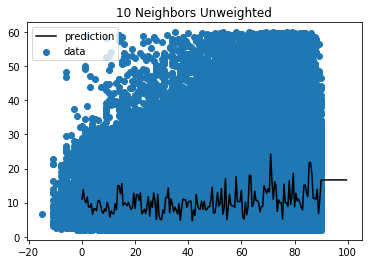

In [9]:
plt.scatter(x, y, label = 'data')
plt.plot(T, Y_, c = 'black', label = 'prediction')
plt.legend()
plt.title("{} Neighbors Unweighted".format(10))
plt.show()
    

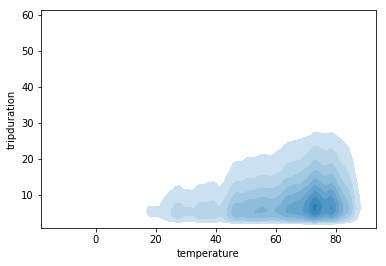

In [23]:
sns.kdeplot(data = yr_1.temperature, data2 = yr_1.tripduration, shade = True, shade_lowest = False)

#### Trying the weighted version

In [25]:
trial = yr_1.loc[(yr_1['temperature'] >= 50) & (yr_1['temperature'] <= 82) &
         (yr_1['tripduration'] >= 0) & (yr_1['temperature'] >= 3)]

In [26]:
# Now the weighted/distance model:

knn_w = neighbors.KNeighborsRegressor(n_neighbors = 5, weights = 'distance')

x1 = pd.DataFrame(trial['temperature'])
y1 = pd.DataFrame(trial['tripduration'])
    

In [27]:
knn_w.fit(x1, y1)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [28]:
T1 = np.arange(0, 100, 0.5)[:, np.newaxis]  

Y1_ = knn_w.predict(T1) 

In [29]:
cross_val_score(knn_w, x1, y1, cv = 10)
    

array([-0.15205908, -0.13989772, -0.14345158, -0.21136611, -0.17509362,
       -0.57465071, -0.30524447, -0.28852323, -0.24227112, -0.22968989])

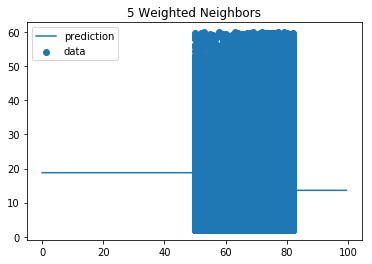

In [34]:
plt.scatter(x1, y1, label = 'data')
plt.plot(T1, Y1_, label = 'prediction')
plt.legend()
plt.title("5 Weighted Neighbors")
plt.show()

### Re-do:

This is the point where I remembered to engineer my own column for the target data.  So, here we go again:  

In [71]:
trial = pd.DataFrame(data.loc[(data['tripduration'] <= 3) & (data['tripduration'] >= 0) &
         (data['temperature'] <= 40) & (data['temperature'] >= 20)])

temp = trial.groupby('temperature').transform('count')

trial['temp_count'] = temp['trip_id']
trial['temp_percent'] = (trial['temp_count'])*100 / 54404

In [72]:
knn_x = neighbors.KNeighborsRegressor(n_neighbors = 4, weights = 'distance')

a = pd.DataFrame(trial.temperature)
b = pd.DataFrame(trial.temp_percent)

knn_x.fit(a, b)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='distance')

In [76]:
Tx = np.arange(20, 45, 0.1)[:, np.newaxis]  

Yx_ = knn_x.predict(Tx) 

In [77]:
cross_val_score(knn_x, a, b, cv = 6)

array([0.99972982, 1.        , 1.        , 1.        , 1.        ,
       1.        ])

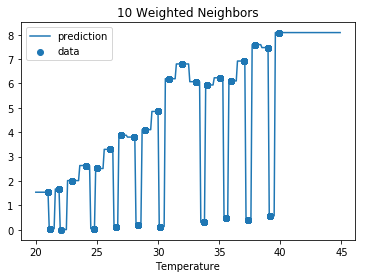

In [78]:
plt.scatter(a, b, label = 'data')
plt.plot(Tx, Yx_, label = 'prediction')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("")
plt.title("10 Weighted Neighbors")
plt.show()

While these scores show that I have successfully reversed the problem, it is, however, a reversed problem.  Somehow, this is overfitting and I am not sure if I have made an error (which is my current guess) or if I have some more tweaking to do. 

In [35]:
# was having trouble making this function work, but not sure why - figured we could look at it if we have time?

def model_uw(dataset, column1, column2, neighbors, pr_range_1, pr_range_2, pr_interval, folds):
    
    knn = neighbors.KNeighborsRegressor(n_neighbors = neighbors)

    x = pd.DataFrame(dataset['column1'])
    y = pd.DataFrame(dataset['column2'])

    knn.fit(x, y)

    T = np.arange(pr_range_1, pr_range_2, pr_interval)[:, np.newaxis]

    Y_ = knn.predict(T)
    
    cross_val_score(knn, x, y, cv = folds)
    
    plt.scatter(x, y, label = 'data')
    plt.plot(T, Y_, label = 'prediction')
    plt.legend()
    plt.title("{} Neighbors Unweighted".format(neighbors))
    plt.show()
    